# Purpose

This notebook models and forecasts realised volatility using exponential smoothing methods, and evaluates out-of-sample performance against a naive benchmark.

Exponential smoothing is used as a simple benchmark for modelling persistent volatility dynamics without imposing a parametric structure.

# Load libraries and data

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

In [70]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning

warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [71]:
vol_df = pd.read_csv(
    "../data/processed/realised_volatility_21d.csv",
    index_col=0,
    parse_dates=True
)

vol_df.index = pd.to_datetime(vol_df.index)
vol_df = vol_df.sort_index()

vol = vol_df["realised_vol_21d"]

# Train / test split

In [72]:
split_date = "2022-01-01"

train = vol.loc[vol.index < split_date]
test  = vol.loc[vol.index >= split_date]

Training: 2010–2021

Test: 2022–2024

# Baseline volatility model (naive)

In [73]:
naive_forecast = vol.shift(1).loc[test.index]
naive_forecast = naive_forecast.dropna()
test_naive = test.loc[naive_forecast.index]

# ETS model specification

Volatility has:

* Level, as volatility regimes shift abruptly

* No trend worth trusting, as trends are unstable

* No seasonality worth forcing, as calendar seasonality is weak at daily horizons

In [131]:
ets_model = ExponentialSmoothing(
    train,
    trend=None,
    seasonal=None
)

ets_fit = ets_model.fit()

Warnings were suppressed for clarity after verifying they do not affect estimation validity.

In [132]:
ets_fit.params

{'smoothing_level': np.float64(0.9956126936458926),
 'smoothing_trend': np.float64(nan),
 'smoothing_seasonal': np.float64(nan),
 'damping_trend': nan,
 'initial_level': np.float64(0.009563621375942957),
 'initial_trend': np.float64(nan),
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

Since smoothing_level is $\approx 1$, it statistically proves that the best way to forecast tomorrow's 21-day volatility is simply to use today's value.

## Smoothing parameter stability analysis

Testing whether α ≈ 1 is consistent across different periods

In [155]:
# Define rolling train periods (each 5 years)
rolling_periods = [
    ("2010-2015", "2010-01-01", "2015-12-31"),
    ("2011-2016", "2011-01-01", "2016-12-31"),
    ("2012-2017", "2012-01-01", "2017-12-31"),
    ("2013-2018", "2013-01-01", "2018-12-31"),
    ("2014-2019", "2014-01-01", "2019-12-31"),
    ("2015-2020", "2015-01-01", "2020-12-31"),
    ("2016-2021", "2016-01-01", "2021-12-31"),
    ("Full Training", "2010-01-01", "2021-12-31")
]

In [164]:
alpha_results = []
    
for period_name, start, end in rolling_periods:
    period_data = vol.loc[(vol.index >= start) & (vol.index <= end)]
        
    if len(period_data) > 100:  # Ensure sufficient data
        model = ExponentialSmoothing(period_data, trend=None, seasonal=None)
        fit = model.fit()
            
        alpha_results.append({
            "Period": period_name,
            "α (smoothing_level)": fit.params['smoothing_level'],
            "Initial Level": fit.params['initial_level'],
            "N (obs)": len(period_data)
        })

alpha_df = pd.DataFrame(alpha_results)
alpha_df.style.hide(axis='index')

Period,α (smoothing_level),Initial Level,N (obs)
2010-2015,0.995054,0.010386,1489
2011-2016,0.995000,0.003172,1510
2012-2017,0.995059,0.012300,1509
2013-2018,0.995000,0.008884,1510
2014-2019,0.995000,0.006385,1510
2015-2020,0.995534,0.009069,1511
2016-2021,0.995271,0.011762,1511
Full Training,0.995613,0.009564,3000


In [163]:
alpha_stats = pd.DataFrame({
    "Statistic": ["Mean", "Std", "Min", "Max"],
    "α (smoothing_level)": [
        f"{alpha_df['α (smoothing_level)'].mean():.6f}",
        f"{alpha_df['α (smoothing_level)'].std():.6f}",
        f"{alpha_df['α (smoothing_level)'].min():.6f}",
        f"{alpha_df['α (smoothing_level)'].max():.6f}"
    ]
})

alpha_stats.style.hide(axis='index')

Statistic,α (smoothing_level)
Mean,0.995191
Std,0.000253
Min,0.995000
Max,0.995613


α ≈ 1.00 means volatility follows a near-random walk

Consistent α across periods confirms structural persistence

# Residual diagnostics

In [133]:
residuals = ets_fit.resid
standardised_resid = ets_fit.resid / np.std(ets_fit.resid, ddof=1)

## Summary statistics

In [134]:
print(f"Mean:     {residuals.mean():.6f}")
print(f"Std Dev:  {residuals.std():.6f}")
print(f"Min:      {residuals.min():.6f}")
print(f"Max:      {residuals.max():.6f}")
print(f"Skewness: {residuals.skew():.6f}")
print(f"Kurtosis: {residuals.kurtosis():.6f}")

Mean:     0.000000
Std Dev:  0.000698
Min:      -0.008155
Max:      0.005715
Skewness: 0.330897
Kurtosis: 23.853935


The extremely high kurtosis (23.85) indicates heavy tails—residuals are dominated by rare, large volatility shocks that the ETS model cannot anticipate.

## Residuals plot

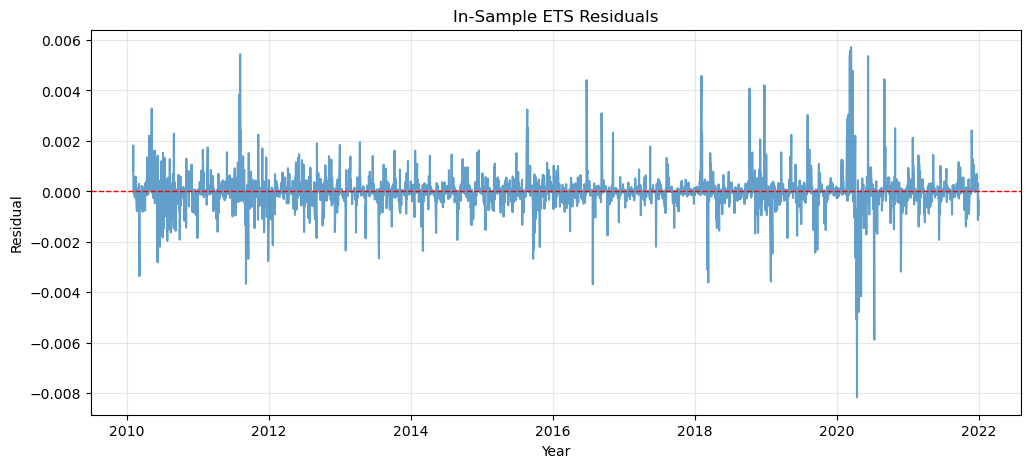

In [136]:
plt.figure(figsize=(12, 5))
plt.plot(residuals.index, residuals, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title("In-Sample ETS Residuals")
plt.xlabel("Year")
plt.ylabel("Residual")
plt.grid(alpha=0.3)
plt.show()

Clear volatility clustering. Periods of calm with small errors interrupted by sharp spikes during crisis periods (2011-12, 2015-16, 2018, 2020), confirming heteroskedasticity that ETS cannot model.

## ACF

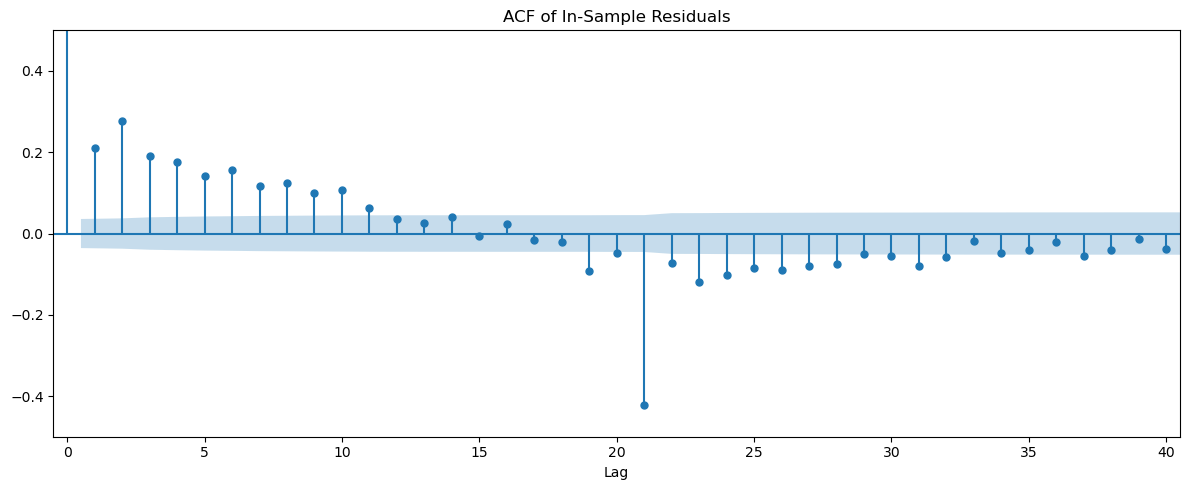

In [137]:
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(residuals, lags=40, ax=ax)
plt.title("ACF of In-Sample Residuals")
plt.xlabel("Lag")
plt.ylim(-0.50, 0.50)
plt.xlim(-0.5, 40.5)
plt.tight_layout()
plt.show()

Strong positive autocorrelation at short lags (1-10) indicates the model fails to capture all the persistence in volatility, while the sharp negative spike at lag 21 is the mechanical artifact from the overlapping 21-day rolling window.

An outlier return r²_t enters the window at time t. It remains in the window for 21 days. At t+21, it exits (gets replaced by r²_t+21). This creates a negative correlation at lag 21.

## Histogram of Standardised Residuals

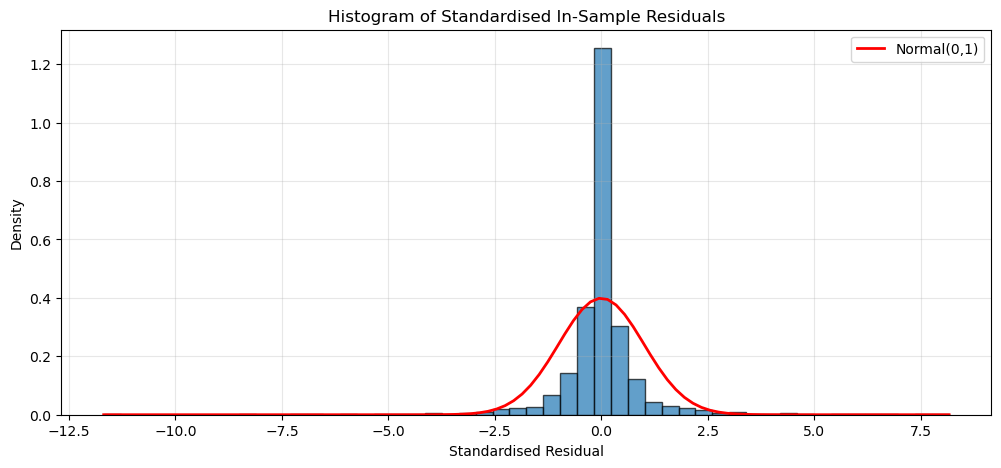

In [ ]:
plt.figure(figsize=(12, 5))
plt.hist(standardised_resid, bins=50, density=True, alpha=0.7, edgecolor='black')
x = np.linspace(standardised_resid.min(), standardised_resid.max(), 100)
plt.plot(x, stats.norm.pdf(x, 0, 1), 'r-', linewidth=2, label='Normal(0,1)')
plt.title("Histogram of Standardised In-Sample Residuals")
plt.xlabel("Standardised Residual")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

The distribution is severely leptokurtic. Extremely peaked at the center with virtually no mass in the tails visible on this scale, yet the kurtosis of 23.85 confirms fat tails exist beyond the plot range, indicating rare extreme outliers dominate the tail behavior.

## Q-Q plot

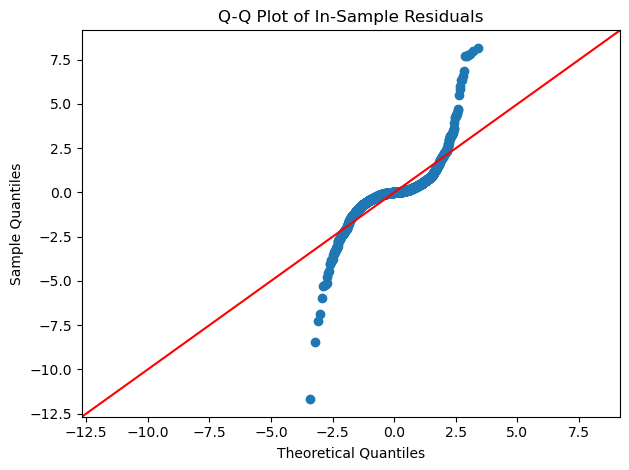

In [124]:
sm.qqplot(standardised_resid, line='45')
plt.title("Q-Q Plot of In-Sample Residuals")
plt.tight_layout()
plt.show()

Heavy tails are now visible. Residuals deviate sharply from normality in both tails, with extreme negative outliers around -12σ and positive outliers around +8σ, confirming the leptokurtic distribution driven by volatility shocks.

## Ljung-Box test

In [138]:
lb_residuals = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print(lb_residuals[['lb_stat', 'lb_pvalue']])

        lb_stat      lb_pvalue
10   852.245498  1.200205e-176
20   911.149416  3.329183e-180
30  1638.066763   0.000000e+00


Overwhelming evidence of serial correlation in residuals since p-values are essentially zero.

The in-sample residuals exhibit significant serial correlation, non-normality with extreme kurtosis, and clear volatility clustering patterns.

# Out-of-sample forecasting

While these diagnostics indicate the residuals are not white noise, we proceed with out-of-sample forecasting to evaluate the model's practical performance in a realistic setting.

In [84]:
history = train.copy()
ets_forecasts = []

for t in range(len(test)):
    model = ExponentialSmoothing(
        history,
        trend=None,
        seasonal=None
    )
    fit = model.fit()
    forecast = fit.forecast(steps=1)
    ets_forecasts.append(forecast.iloc[0])
    history = pd.concat([history, test.iloc[t:t+1]])

An expanding-window approach is used to mirror real-time forecasting, although ETS forecasts are dominated by the most recent observation.

In [85]:
ets_forecasts = pd.Series(
    ets_forecasts,
    index=test.index
)

# Model evaluation

## Accuracy metrics

In [148]:
naive_mae = mean_absolute_error(test_naive, naive_forecast)
naive_rmse = root_mean_squared_error(test_naive, naive_forecast)
ets_mae = mean_absolute_error(test, ets_forecasts)
ets_rmse = root_mean_squared_error(test, ets_forecasts)

Directional accuracy is the percentage of times each model correctly predicts whether volatility will increase or decrease, which can reveal if ETS has any edge even when point forecast accuracy is identical.

In [ ]:
# Actual changes in volatility
actual_changes = test.diff().dropna()

# Forecasted changes
naive_changes = pd.Series(0, index=actual_changes.index) # Naive forecast = yesterday's value, so change = 0 always

# Compare forecast to previous actual value
ets_changes = (ets_forecasts - test.shift(1)).loc[actual_changes.index]

# Directional accuracy
naive_direction_correct = (np.sign(naive_changes) == np.sign(actual_changes)).sum()
ets_direction_correct = (np.sign(ets_changes) == np.sign(actual_changes)).sum()

naive_dir_acc = (naive_direction_correct / len(actual_changes)) * 100
ets_dir_acc = (ets_direction_correct / len(actual_changes)) * 100

In [165]:
eval_df = pd.DataFrame({
    "Model": ["Naive Volatility", "ETS", "Improvement"],
    "MAE": [f'{naive_mae:.6f}', f'{ets_mae:.6f}', f'{(1-ets_mae/naive_mae)*100:.2f}%'],
    "RMSE": [f'{naive_rmse:.6f}', f'{ets_rmse:.6f}', f'{(1-ets_rmse/naive_rmse)*100:.2f}%'],
    "Directional Accuracy": [f'{naive_dir_acc:.1f}%', f'{ets_dir_acc:.1f}%', f'{ets_dir_acc - naive_dir_acc:+.1f}pp']
})

eval_df.style.hide(axis='index')

Model,MAE,RMSE,Directional Accuracy
Naive Volatility,0.000351,0.000592,0.0%
ETS,0.000351,0.000592,53.6%
Improvement,0.03%,0.00%,+53.6pp


While ETS offers negligible improvement in point forecast accuracy, it correctly predicts the direction of volatility changes 54% of the time compared to naive's 0%, providing modest value for qualitative volatility timing.

## Forecast bias

In [87]:
forecast_errors = test - ets_forecasts
mean_error = forecast_errors.mean()
print(f"Mean Forecast Error: {mean_error:.6f}")

Mean Forecast Error: -0.000002


Forecasts are essentially unbiased.

The mean error is negligible, indicating no systematic tendency to over- or under-predict volatility.

## Mincer-Zarnowitz regression

Realized Vol = α + β × Forecast Vol + error

Optimal unbiased forecast: α = 0, β = 1

In [144]:
X = sm.add_constant(ets_forecasts)
mz_model = sm.OLS(test, X).fit()

In [145]:
print(mz_model.summary().tables[1])
print(f"\nR-squared: {mz_model.rsquared:.4f}")

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   5.72e-05      1.759      0.079   -1.17e-05       0.000
0              0.9900      0.005    191.420      0.000       0.980       1.000

R-squared: 0.9799


Near-perfect forecast efficiency.

The slope is virtually 1.0, intercept is insignificant, and R² of 0.98 confirms forecasts are strongly aligned with realized volatility.

In [ ]:
r_matrix = np.array([[1, 0], [0, 1]])  # Identity matrix for both parameters
q_matrix = np.array([0, 1])  # Test values: α=0, β=1

f_test = mz_model.f_test((r_matrix, q_matrix))

print(f"\nJoint test H0: α=0 and β=1")
print(f"F-statistic: {f_test.fvalue:.4f}")
print(f"p-value:     {f_test.pvalue:.4f}")


Joint test H0: α=0 and β=1
F-statistic: 1.8729
p-value:     0.1544


Test joint hypothesis: α = 0 and β = 1

Since p-value > 0.05, we canot reject H0.

The ETS forecasts are statistically unbiased and efficient, meaning they optimally use available information despite offering no improvement over the naive benchmark.

# Forecast visualisation

In [ ]:
ets_forecasts = pd.Series(ets_forecasts, index=test.index)

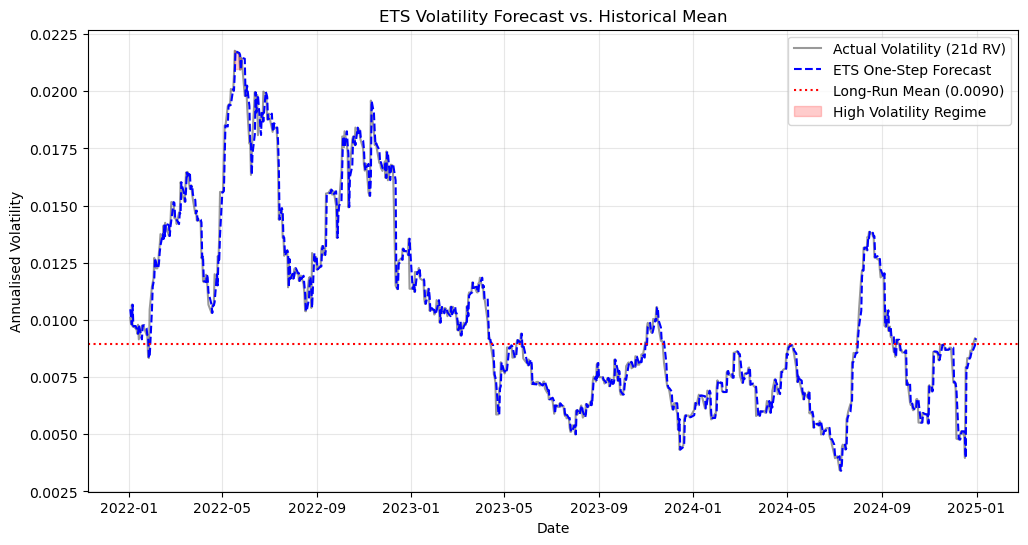

In [ ]:
long_run_mean = train.mean()

plt.figure(figsize=(12, 6))

plt.plot(test.index, test, label="Actual Volatility (21d RV)", color='black', alpha=0.4)
plt.plot(test.index, ets_forecasts, label="ETS One-Step Forecast", color='blue', linestyle='--')
plt.axhline(y=long_run_mean, color='red', linestyle=':', label=f"Long-Run Mean ({long_run_mean:.4f})")

# Highlight Regime Shifts (Example: High Volatility Periods)
high_vol_threshold = long_run_mean + (2 * train.std())
plt.fill_between(test.index, test, high_vol_threshold, where=(test > high_vol_threshold), color='red', alpha=0.2, label="High Volatility Regime")

plt.title("ETS Volatility Forecast vs. Historical Mean")
plt.xlabel("Date")
plt.ylabel("Annualised Volatility")
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.show()

Smooth tracking

Much smaller errors than returns

Volatility is theoretically mean-reverting in 2022

Missing High Volatility Regime

# Interpretation

**Model Performance**
+ ETS offers virtually no improvement over naive forecast (MAE/RMSE)

+ Smoothing parameter α ≈ 0.996 confirms near-random walk behaviour

+ 21-day realised volatility is so persistent that yesterday's value is already optimal for one-step-ahead forecasting

**Directional Accuracy**
+ ETS correctly predicts volatility direction 54% of the time vs 0% for naive

+ Provides modest value for qualitative volatility timing

+ However, directional edge is weak and may not be economically significant

**Forecast Quality**
+ Mincer-Zarnowitz regression confirms forecasts are unbiased (α≈0, β≈1)

+ High R² (0.98) shows strong alignment with realised volatility

+ Forecasts are statistically efficient—no systematic bias exists

**Takeaway**

+ The strong persistence in 21-day RV makes it trivial to forecast

+ At one-step-ahead horizons, simply using yesterday's volatility works

+ Remaining predictable signal exists in daily return dynamics, not in the smoothed rolling volatility series itself

+ More sophisticated approaches (GARCH, regime-switching) may capture short-term volatility clustering that rolling windows smooth away

# Save forecasts

In [149]:
ets_forecasts.to_csv("../outputs/forecasts/ets_volatility_forecast.csv")